<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 2
epochs = 50
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 40
vae.train()

for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 189.1984
Epoch 2, Loss: 167.0311
Epoch 3, Loss: 163.4738
Epoch 4, Loss: 161.4853
Epoch 5, Loss: 159.8622
Epoch 6, Loss: 158.5316
Epoch 7, Loss: 157.3530
Epoch 8, Loss: 156.2916
Epoch 9, Loss: 155.3674
Epoch 10, Loss: 154.6048
Epoch 11, Loss: 153.9261
Epoch 12, Loss: 153.3973
Epoch 13, Loss: 152.8407
Epoch 14, Loss: 152.4031
Epoch 15, Loss: 151.9719
Epoch 16, Loss: 151.5895
Epoch 17, Loss: 151.2448
Epoch 18, Loss: 150.8682
Epoch 19, Loss: 150.5568
Epoch 20, Loss: 150.2793
Epoch 21, Loss: 150.0607
Epoch 22, Loss: 149.7247
Epoch 23, Loss: 149.4921
Epoch 24, Loss: 149.2417
Epoch 25, Loss: 149.0379
Epoch 26, Loss: 148.8462
Epoch 27, Loss: 148.5959
Epoch 28, Loss: 148.4082
Epoch 29, Loss: 148.2284
Epoch 30, Loss: 148.0442
Epoch 31, Loss: 147.8773
Epoch 32, Loss: 147.7421
Epoch 33, Loss: 147.5678
Epoch 34, Loss: 147.3948
Epoch 35, Loss: 147.2467
Epoch 36, Loss: 147.0576
Epoch 37, Loss: 146.9578
Epoch 38, Loss: 146.7806
Epoch 39, Loss: 146.6874
Epoch 40, Loss: 146.6018


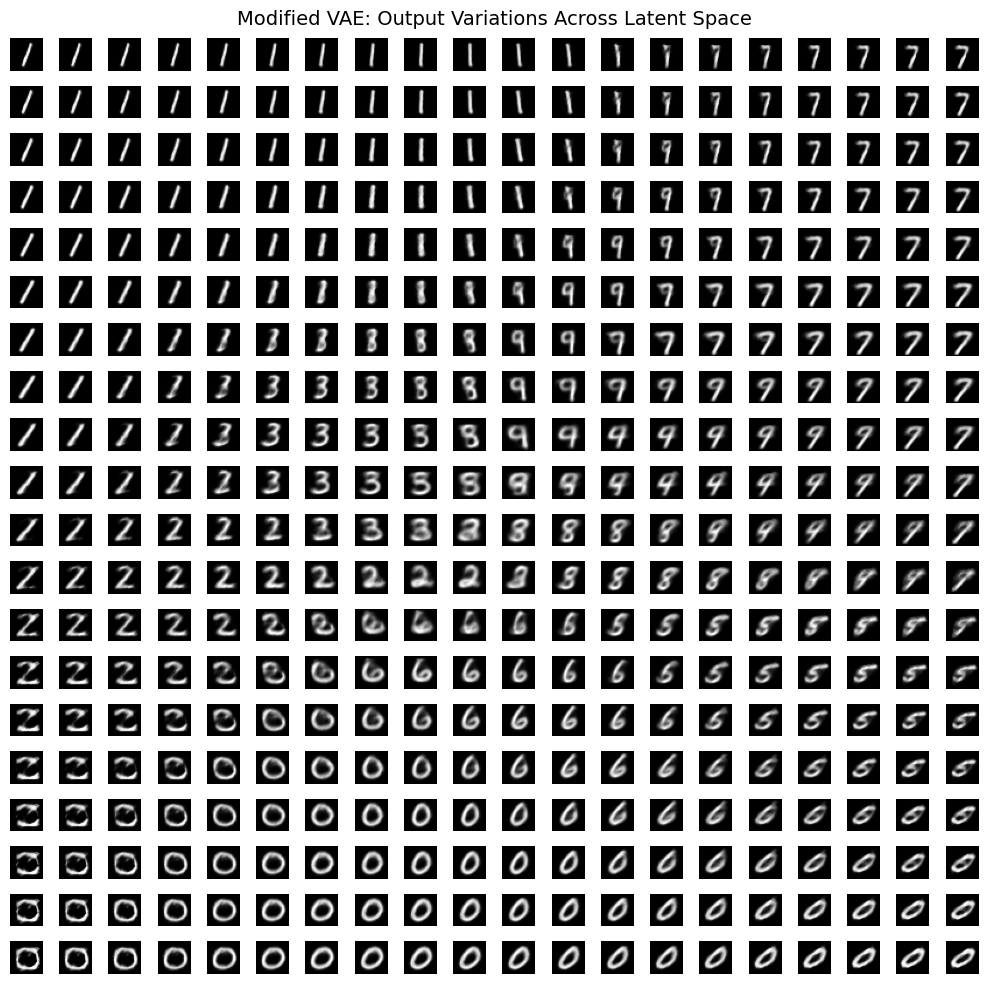

In [ ]:
# Assume 2D latent space for visualization
n = 20  # Grid size
figure = plt.figure(figsize=(10, 10))
grid_x = torch.linspace(-3, 3, n)
grid_y = torch.linspace(-3, 3, n)

vae.eval()
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]])  # Sample z from grid
        with torch.no_grad():
            x_decoded = vae.decoder(z_sample)
        digit = x_decoded.view(28, 28).numpy()
        ax = plt.subplot(n, n, i * n + j + 1)
        plt.imshow(digit, cmap="gray")
        plt.axis("off")

plt.suptitle("Modified VAE: Output Variations Across Latent Space", fontsize=14)
plt.tight_layout()
plt.show()
